In [1]:
%matplotlib notebook

import sys, os
sys.path.append("/home/daniil/repos/pytorch-segmentation-detection/")
sys.path.insert(0, '/home/daniil/repos/pytorch-segmentation-detection/vision/')

# Use second GPU -pytorch-segmentation-detection- change if you want to use a first one
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from pytorch_segmentation_detection.datasets.endovis_instrument_2017 import Endovis_Instrument_2017
import pytorch_segmentation_detection.models.fcn as fcns
import pytorch_segmentation_detection.models.resnet_dilated as resnet_dilated
from pytorch_segmentation_detection.transforms import (ComposeJoint,
                                                       RandomHorizontalFlipJoint,
                                                       RandomScaleJoint,
                                                       CropOrPad,
                                                       ResizeAspectRatioPreserve)

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms

import numbers
import random

from matplotlib import pyplot as plt

import numpy as np
from PIL import Image

from sklearn.metrics import confusion_matrix

def flatten_logits(logits, number_of_classes):
    """Flattens the logits batch except for the logits dimension"""
    
    logits_permuted = logits.permute(0, 2, 3, 1)
    logits_permuted_cont = logits_permuted.contiguous()
    logits_flatten = logits_permuted_cont.view(-1, number_of_classes)
    
    return logits_flatten

def flatten_annotations(annotations):
    
    return annotations.view(-1)

def get_valid_annotations_index(flatten_annotations, mask_out_value=255):
    
    return torch.squeeze( torch.nonzero((flatten_annotations != mask_out_value )), 1)


from pytorch_segmentation_detection.transforms import RandomCropJoint

number_of_classes = 2

labels = range(number_of_classes)

train_transform = ComposeJoint(
                [
                    # Crop to the actual view of the endoscop camera
                    [transforms.CenterCrop((1024, 1280)), transforms.CenterCrop((1024, 1280))],
                    RandomHorizontalFlipJoint(),
                    RandomCropJoint(crop_size=(224, 224)),
                    [transforms.ToTensor(), None],
                    [transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), None],
                    [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
                ])

trainset = Endovis_Instrument_2017(root='/home/daniil/projects/endovis/dataset/',
                                   dataset_type=0,
                                   joint_transform=train_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=4)



valid_transform = ComposeJoint(
                [
                     [transforms.CenterCrop((1024, 1280)), transforms.CenterCrop((1024, 1280))],
                     [transforms.ToTensor(), None],
                     [transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), None],
                     [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
                ])


valset = Endovis_Instrument_2017(root='/home/daniil/projects/endovis/dataset/',
                                 dataset_type=0,
                                 joint_transform=valid_transform,
                                 train=False)

valset_loader = torch.utils.data.DataLoader(valset, batch_size=1,
                                            shuffle=False, num_workers=2)

train_subset_sampler = torch.utils.data.sampler.SubsetRandomSampler(xrange(223))
train_subset_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=1,
                                                   sampler=train_subset_sampler,
                                                   num_workers=2)


# Define the validation function to track MIoU during the training
def validate():
    
    fcn.eval()
    
    overall_confusion_matrix = None

    for image, annotation in valset_loader:

        image = Variable(image.cuda())
        logits = fcn(image)

        # First we do argmax on gpu and then transfer it to cpu
        logits = logits.data
        _, prediction = logits.max(1)
        prediction = prediction.squeeze(1)

        prediction_np = prediction.cpu().numpy().flatten()
        annotation_np = annotation.numpy().flatten()

        # Mask-out value is ignored by default in the sklearn
        # read sources to see how that was handled

        current_confusion_matrix = confusion_matrix(y_true=annotation_np,
                                                    y_pred=prediction_np,
                                                    labels=labels)

        if overall_confusion_matrix is None:


            overall_confusion_matrix = current_confusion_matrix
        else:

            overall_confusion_matrix += current_confusion_matrix
    
    
    intersection = np.diag(overall_confusion_matrix)
    ground_truth_set = overall_confusion_matrix.sum(axis=1)
    predicted_set = overall_confusion_matrix.sum(axis=0)
    union =  ground_truth_set + predicted_set - intersection

    intersection_over_union = intersection / union.astype(np.float32)
    mean_intersection_over_union = np.mean(intersection_over_union)
    
    fcn.train()

    return mean_intersection_over_union


def validate_train():
    
    fcn.eval()
    
    overall_confusion_matrix = None

    for image, annotation in train_subset_loader:

        image = Variable(image.cuda())
        logits = fcn(image)

        # First we do argmax on gpu and then transfer it to cpu
        logits = logits.data
        _, prediction = logits.max(1)
        prediction = prediction.squeeze(1)

        prediction_np = prediction.cpu().numpy().flatten()
        annotation_np = annotation.numpy().flatten()

        # Mask-out value is ignored by default in the sklearn
        # read sources to see how that was handled

        current_confusion_matrix = confusion_matrix(y_true=annotation_np,
                                                    y_pred=prediction_np,
                                                    labels=labels)

        if overall_confusion_matrix is None:


            overall_confusion_matrix = current_confusion_matrix
        else:

            overall_confusion_matrix += current_confusion_matrix
    
    
    intersection = np.diag(overall_confusion_matrix)
    ground_truth_set = overall_confusion_matrix.sum(axis=1)
    predicted_set = overall_confusion_matrix.sum(axis=0)
    union =  ground_truth_set + predicted_set - intersection

    intersection_over_union = intersection / union.astype(np.float32)
    mean_intersection_over_union = np.mean(intersection_over_union)
    
    fcn.train()

    return mean_intersection_over_union



<IPython.core.display.Javascript object>


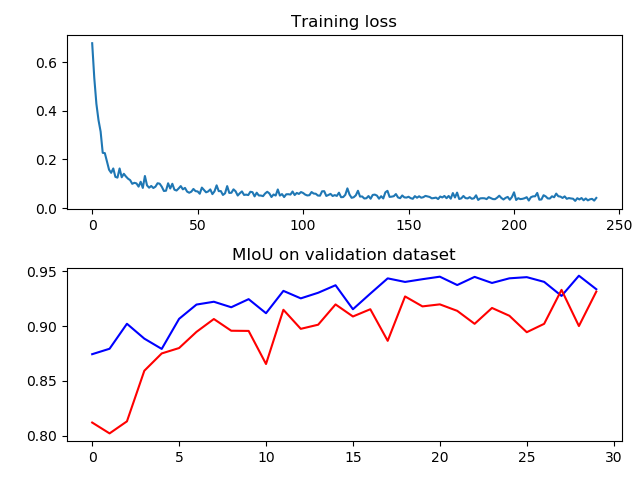

In [2]:
%matplotlib notebook

from matplotlib import pyplot as plt


# Create the training plot
loss_current_iteration = 0
loss_history = []
loss_iteration_number_history = []

validation_current_iteration = 0
validation_history = []
validation_iteration_number_history = []

train_validation_current_iteration = 0
train_validation_history = []
train_validation_iteration_number_history = []
 
f, (loss_axis, validation_axis) = plt.subplots(2, 1)

loss_axis.plot(loss_iteration_number_history, loss_history)
validation_axis.plot(validation_iteration_number_history, validation_history, 'b',
                     train_validation_iteration_number_history, train_validation_history, 'r')

loss_axis.set_title('Training loss')
validation_axis.set_title('MIoU on validation dataset')

plt.tight_layout()

In [3]:
## Define the model and load it to the gpu
fcn = resnet_dilated.Resnet18_8s(num_classes=2)
fcn.cuda()
fcn.train()

# Uncomment to preserve BN statistics
#fcn.eval()
# for m in fcn.modules():

#     if isinstance(m, nn.BatchNorm2d):
#         m.weight.requires_grad = False
#         m.bias.requires_grad = False

## Define the loss and load it to gpu
#optimizer = optim.Adam(filter(lambda p: p.requires_grad, fcn.parameters()), lr=0.00001, weight_decay=0.0005)

criterion = nn.CrossEntropyLoss(size_average=False).cuda()

optimizer = optim.Adam(fcn.parameters(), lr=0.0001, weight_decay=0.0001)

/home/daniil/repos/anaconda2/lib/python2.7/site-packages/torch/nn/modules/module.py:360: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  own_state[name].copy_(param)


In [4]:
best_validation_score = 0

iter_size = 20

for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs
        img, anno = data
        
        # We need to flatten annotations and logits to apply index of valid
        # annotations. All of this is because pytorch doesn't have tf.gather_nd()
        anno_flatten = flatten_annotations(anno)
        index = get_valid_annotations_index(anno_flatten, mask_out_value=255)
        anno_flatten_valid = torch.index_select(anno_flatten, 0, index)

        # wrap them in Variable
        # the index can be acquired on the gpu
        img, anno_flatten_valid, index = Variable(img.cuda()), Variable(anno_flatten_valid.cuda()), Variable(index.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        logits = fcn(img)
        logits_flatten = flatten_logits(logits, number_of_classes=2)
        logits_flatten_valid = torch.index_select(logits_flatten, 0, index)
        
        loss = criterion(logits_flatten_valid, anno_flatten_valid)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.data[0] / logits_flatten_valid.size(0)) 
        if i % 2 == 1:
            
            
            loss_history.append(running_loss / 2)
            loss_iteration_number_history.append(loss_current_iteration)
            
            loss_current_iteration += 1
            
            loss_axis.lines[0].set_xdata(loss_iteration_number_history)
            loss_axis.lines[0].set_ydata(loss_history)

            loss_axis.relim()
            loss_axis.autoscale_view()
            loss_axis.figure.canvas.draw()
            
            running_loss = 0.0
            
        
            
    current_validation_score = validate()
    validation_history.append(current_validation_score)
    validation_iteration_number_history.append(validation_current_iteration)

    validation_current_iteration += 1

    validation_axis.lines[0].set_xdata(validation_iteration_number_history)
    validation_axis.lines[0].set_ydata(validation_history)



    current_train_validation_score = validate_train()
    train_validation_history.append(current_train_validation_score)
    train_validation_iteration_number_history.append(train_validation_current_iteration)

    train_validation_current_iteration += 1

    validation_axis.lines[1].set_xdata(train_validation_iteration_number_history)
    validation_axis.lines[1].set_ydata(train_validation_history)


    validation_axis.relim()
    validation_axis.autoscale_view()
    validation_axis.figure.canvas.draw()

    # Save the model if it has a better MIoU score.
    if current_validation_score > best_validation_score:

        torch.save(fcn.state_dict(), 'resnet_18_8s_best.pth')
        best_validation_score = current_validation_score
        
                

print('Finished Training')

/home/daniil/repos/anaconda2/lib/python2.7/site-packages/torch/nn/functional.py:961: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


Finished Training
